# Data Generation
## Goals
* The main goal of this notebook is to generate training data for mnist object detection project
* We are going to break this task into following sub-tasks
    1. Extend `mnist` dataset with augmented data and bounding boxes
    1. Map the `n` digits to larger 100x100 images which will be used for training
* Both these tasks are further broken down into smaller tasks for easier experimentation. 
* The output of this notebook will be a bunch of reusable functions or scripts that we can use generate different training dataset for different phase of the project

## Import Libraries

In [1]:
## import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import PIL.Image

2025-07-20 14:37:46.800391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753047466.818843   51500 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753047466.824458   51500 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753047466.839387   51500 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753047466.839404   51500 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753047466.839405   51500 computation_placer.cc:177] computation placer alr

In [2]:
## validate tensorflow 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Constants

In [3]:
data_dir = Path("..","data")
models_dir = Path("..","models")

## Read Data

In [4]:
data = pd.read_csv(Path(data_dir,"raw","raw_mnist_data.csv"))
data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Bounding Box Generatibon

In [5]:
## helper function to plot the mnist data instances
def plot_numbers(image_df):
    ## lets render each image to do a quick visual inspection
    num_instances = image_df.shape[0]
    num_of_columns = 5
    num_of_rows = int(num_instances / num_of_columns) + (1 if int(num_instances % num_of_columns) > 0 else 0)
    fig,axs = plt.subplots(num_of_rows,num_of_columns,figsize=(10,3))    
    axs = axs.ravel()
    for idx in range(0,num_instances,1):
        image_data = image_df.iloc[idx].values.reshape(28, 28)  # MNIST images are 28x28 pixels
        # Render the image using Matplotlib
        axs[idx].imshow(image_data)  # Use 'gray' colormap to render grayscale
        
        
    plt.axis("off") # Remove axes for better visualization    
    plt.show()

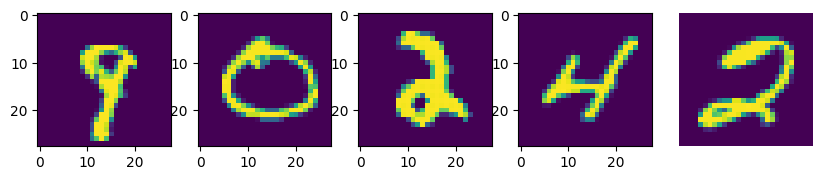

In [6]:
plot_numbers(data.sample(5).drop(columns=["class"]))

In [7]:
## lets use a small sample to test our function as we implement it
test_pixels = data.sample(2)

In [8]:
## helper function to calculate bounding box for each instance and return it. 
def map_bounding_box(mnist_intance):
    padding = 1
    ## save the current class for later
    curr_class = mnist_intance["class"]
    
    ## extract pixel information
    pixels = mnist_intance.drop(labels=["class"])
    ## reshape the pixels 
    pixels = pixels.values.reshape(28,28)
    
    ## calculate active rows & columns
    active_rows = np.sum(pixels,axis=1)
    active_columns = np.sum(pixels, axis=0)
    
    ## calculate x_min and x_max coordinate
    x_min = np.nonzero(active_columns)[0][0]
    x_max = np.nonzero(active_columns)[0][-1]
    y_min = np.nonzero(active_rows)[0][0]
    y_max = np.nonzero(active_rows)[0][-1]

    ## add padding to pixels
    x_min = x_min - (padding if (x_min != 0) else 0)
    x_max = x_max + (padding if (x_max != 27) else 0)
    y_min = y_min - (padding if (y_min != 0) else 0)
    y_max = y_max + (padding if (y_max != 27) else 0)
    
    ## calcualte x_center and y_center
    x_center = round((x_min + x_max) / 2)
    y_center = round((y_min + y_max) / 2)
    
    ## calculate width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    
    return pd.Series({
        "class": curr_class,
        "x_center": x_center,
        "y_center": y_center,
        "width": width,
        "height": height
    })

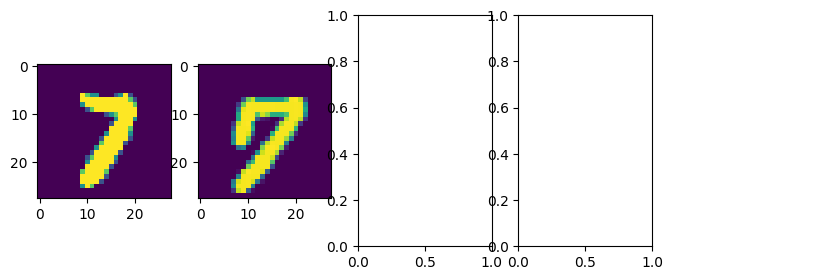

In [9]:
## plot the sample image to mental model 
plot_numbers(test_pixels.drop(columns=["class"]))
test_bounding_box = test_pixels.apply(map_bounding_box,axis=1)

In [10]:
test_bounding_box

,class,x_center,y_center,width,height
16049,7,14,16,14,22
42269,7,14,16,18,22


* So now we have the bounding box coordinates, lets quickly test them by creating the debug function that renders the bounding along with the digit

In [11]:
## since we have class in bounding box dataframe lets drop it from test pixels
test_pixels = test_pixels.drop(columns=["class"])
test_pixels


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
16049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test_bounding_box

,class,x_center,y_center,width,height
16049,7,14,16,14,22
42269,7,14,16,18,22


## Bounding Box Visualization

In [13]:
## right now we don't know how would we uses this function, for now assumption is we'll pass in 2 dataframes
## we'll revisit the function signature as we proceed with the project
from matplotlib import patches

def visualize_bounding_box(pixel_data, target_data,num_of_columns = 5):
    num_of_columns = num_of_columns if num_of_columns <= 5 else 5
    num_instances = pixel_data.shape[0]
    num_of_rows = int(num_instances / num_of_columns) + (1 if int(num_instances % num_of_columns) > 0 else 0)

    fig,axs = plt.subplots(num_of_rows,num_of_columns,figsize=(10,3))    
    axs = axs.ravel()

    for idx in range(0,num_instances,1):

        original = tf.constant(pixel_data.iloc[idx].values.reshape(28,28,1))
        converted = tf.image.grayscale_to_rgb(original)
        
        x_center = target_data.iloc[idx]["x_center"]
        y_center = target_data.iloc[idx]["y_center"]
        width = target_data.iloc[idx]["width"]
        height = target_data.iloc[idx]["height"]
        
        x = round(x_center - (width) / 2)
        y = round(y_center - (height) / 2)

        rect = patches.Rectangle((x,y),width=width,height=height, linewidth=1, edgecolor='r', facecolor='none')
        image_data = converted.numpy().astype("uint8")
        axs[idx].imshow(image_data)
        axs[idx].add_patch(rect)
        
        axs[idx].set_title(target_data.iloc[idx]["class"])
        axs[idx].axis("off")
    plt.show()

I0000 00:00:1753047473.582337   51500 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6055 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5


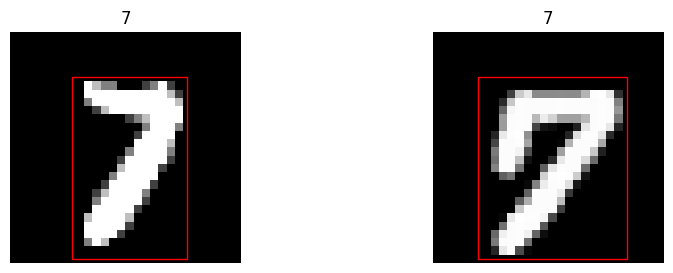

In [14]:
visualize_bounding_box(test_pixels,test_bounding_box, num_of_columns=2)

## Training Data Generation
* In this section we are going to define a simple `map` function that will map a 28x28x1 image to a 100x100x1 image.
* This function will do the following for each 28x28x1 image,
    * Randomly select `(n-1)` additional digits from global mnist dataset. Here `n` defines number of digits to overlay on 100x100x1 image. 
    * Apply `RandomAugmentation` (`RandomZoom`, `RandomTranslation`, `RandomRotation`) to these `n` images
    * Use the bounding box function to define bounding boxes for augmented images.
    * Create a blank 100x100x1 canvas
    * One at a time paste the image on this 100x100x1 canvas, by selecting non overlapping (top,left) coordinates.
    * Recalculate bounding box coordinates based on the new (top,left)
    * Return 100x100x1 image along with new output. 

* Lets break down the above algorithm into modular functions
    * `sample_base_digits(num_of_digits)` - Will return random `num_of_digits` from mnist dataset
    * `augment_digits(digits)` - Will apply random augmentation, we can also extend this to accept factor values to help convert them into hyper params.
    * `calculate_tight_bbox(mnist_instance, debug=False)` - we already have a function (`map_bounding_box`) for this, we **might** need to refactor it a bit for our flow. We can add a debug param to help render the bounded box to make sure its working as expected. 
    * `create_blank_canvas(shape=(100,100,1))` - Will create a default blank canvas to 100x100x1, but can be extended to different sizes if we want to experiment a bit. 
    * `place_digit_on_canvas(image, canvas, existing_coordinates=[])` - This function will overlay the image on top of canvas. It will use `existing_coordinates` to determine the position of the image. This is where we'll implement the logic to make sure images are not overlapping. The function will return (top,left) coordinates of the newly overlaid image.  We **might** break this into multiple functions specially the overlapping logic.  This funciton assumes image shape is 28x28x1 for now. 
    * `translate_bbox_to_canvas(current_bounding_box, coordinates)` - This function converts the existing bounding box into new ones w.r.t. coordinates. Returns the whole new bounding box object. 
    * `generate_training_example()` - Master function that will call all the above functions to generate training example.

* Lets create few sample digits for testing our implementation. After that we'll run it against whole dataset

In [15]:
test_dataset = data.sample(10)
test_dataset

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
37219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
31431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
13800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
34714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
19327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
6242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
46315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
40650,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
57801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


### Sample Base Digits

In [16]:
def sample_base_digits(num_of_digits):
    pass

### Augment Digits

In [17]:
def augment_digits(digits):
    pass

### Calculate Tight BBox

In [18]:
def calculate_tight_box(mnist_instance, debug=False):
    pass

### Create Blank Canvas

In [19]:
def create_blank_canvas(shape=(100,100,1)):
    pass

### Place Digit On Canvas

In [20]:
def place_digit_on_canvas(digit, canvas, existing_coordinates=[]):
    pass

### Translate BBox To Canvas

In [21]:
def translate_bbox_to_canvas(current_bbox, coordinates):
    pass

### Generate Training Example

In [143]:
def generate_training_example(x,y):
    # print(f"y = {y}")
    # print(f"x.shape {x.shape}")
    # print(f"x type {type(x)}")
    canvas = tf.zeros(shape=(100,100,1), dtype=tf.int64)
    ## prediction size 1 + 14(4 for coordinates, 10 for digits) * 5 (max number of digits)
    prediction = tf.zeros(shape=(1,71), dtype=tf.int64)
    return (x,y)

In [144]:
## convert the test dataset to Tensor
test_X = test_dataset.drop(columns=["class"])
test_y = test_dataset["class"]
X_test_tensor = tf.convert_to_tensor(test_dataset)
X_test_tensor.shape

TensorShape([10, 785])

In [145]:
## lets experiment with tensor 
## first dataset has class 1 so will just access its pixels and class.
first_tensor = X_test_tensor[0] # this should give us the first instance of our dataset
pixels = first_tensor[0:784] # this should give us pixels of first instance
class_value = first_tensor[784] # this should give us the class
pixels.shape,class_value.shape,class_value.numpy()

(TensorShape([784]), TensorShape([]), np.int64(8))

* After some research and looking into the docs we've found a more effient way a more TF way to do create map functions.

In [146]:
test_X = test_dataset.drop(columns=["class"])
test_y = test_dataset["class"]

X_test_tensor = tf.convert_to_tensor(test_X)
X_test_tensor = tf.reshape(X_test_tensor,shape=(-1,28,28,1))
y_test_tensor = tf.convert_to_tensor(test_y)


raw_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor,y_test_tensor))

processed_dataset = raw_dataset.map(lambda X,y : tf.numpy_function(generate_training_example,inp=[X,y], Tout=(tf.int64,tf.int64)))
dataset = processed_dataset.enumerate()
for iter, elem in dataset.as_numpy_iterator():
    print(f"elem class : {elem[1]}")

elem class : 8
elem class : 3
elem class : 5
elem class : 0
elem class : 5
elem class : 7
elem class : 8
elem class : 9
elem class : 6
elem class : 3


In [ ]:
X_test_tensor = tf.convert_to_tensor(test_X,dtype=tf.float32)
X_test_tensor = tf.reshape(X_test_tensor,shape=(-1,28,28,1))
y_test_tensor = tf.convert_to_tensor(test_y,dtype=tf.float32)
